In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,cohen_kappa_score, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.layers import (LSTM, RepeatVector, TimeDistributed, Input, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D,
                                     BatchNormalization, LayerNormalization, Add,
                                     Bidirectional, MultiHeadAttention)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import layers, models
from keras_tuner.tuners import RandomSearch

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = "artifacts"
visualization_dir = "visualization"
checkpoint_dir = 'checkpoints'

os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {visualization_dir}")
print(f"Checkpoints will be saved in: {checkpoint_dir}")

All libraries imported successfully!
TensorFlow version: 2.18.0
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization
Checkpoints will be saved in: checkpoints


In [2]:
with open(os.path.join(artifacts_dir, 'data_train_preprocessing.pkl'), 'rb') as f:
    X_train, y_train = pickle.load(f)

In [3]:
print(X_train.shape)
print(y_train.shape)

print(X_train[:10])
print(y_train[:10])

(30739, 20)
(30739, 8)
   longitude  is_weekend  hour_sin  hour_cos  second_cos  is_night   bearing  \
0   0.024929         1.0       0.5       0.0    1.000000       0.0  0.625207   
1   0.023522         1.0       0.5       0.0    1.000000       0.0  0.625608   
2   0.022317         1.0       0.5       0.0    0.997261       0.0  0.626952   
3   0.022692         1.0       0.5       0.0    0.997261       0.0  0.128392   
4   0.022287         1.0       0.5       0.0    0.989074       0.0  0.631384   
5   0.022510         1.0       0.5       0.0    0.989074       0.0  0.120184   
6   0.022908         1.0       0.5       0.0    0.989074       0.0  0.122524   
7   0.023988         1.0       0.5       0.0    0.975528       0.0  0.123765   
8   0.023418         1.0       0.5       0.0    0.975528       0.0  0.623995   
9   0.024579         1.0       0.5       0.0    0.975528       0.0  0.124276   

   bearing_sin  bearing_cos  distance_m_haversine      jerk  \
0     0.145982     0.146912      

In [4]:
with open(os.path.join(artifacts_dir, 'data_val_preprocessing.pkl'), 'rb') as f:
    X_val, y_val = pickle.load(f)

In [5]:
print(X_val.shape)
print(y_val.shape)

print(X_val[:10])
print(y_val[:10])

(4367, 20)
(4367, 8)
   longitude  is_weekend  hour_sin  hour_cos  second_cos  is_night   bearing  \
0   0.116293         1.0       0.5       0.0    0.834565       0.0       NaN   
1   0.100993         1.0       0.5       0.0    0.871572       0.0  0.604193   
2   0.086888         1.0       0.5       0.0    0.904508       0.0  0.612562   
3   0.074229         1.0       0.5       0.0    0.933013       0.0  0.617904   
4   0.063139         1.0       0.5       0.0    0.956773       0.0  0.621142   
5   0.053644         1.0       0.5       0.0    0.975528       0.0  0.623001   
6   0.045698         1.0       0.5       0.0    0.975528       0.0  0.623998   
7   0.039204         1.0       0.5       0.0    0.989074       0.0  0.624500   
8   0.034031         1.0       0.5       0.0    0.989074       0.0  0.624738   
9   0.030032         1.0       0.5       0.0    0.997261       0.0  0.624871   

   bearing_sin  bearing_cos  distance_m_haversine      jerk  \
0          NaN          NaN        

In [6]:
with open(os.path.join(artifacts_dir, 'data_test_preprocessing.pkl'), 'rb') as f:
    X_test, y_test = pickle.load(f)

In [7]:
print(X_test.shape)
print(y_test.shape)

print(X_test[:10])
print(y_test[:10])

(3854, 20)
(3854, 8)
   longitude  is_weekend  hour_sin  hour_cos  second_cos  is_night   bearing  \
0   0.031124         1.0       0.5       0.0    0.654508       0.0  0.585782   
1   0.031183         1.0       0.5       0.0    0.654508       0.0  0.140861   
2   0.031234         1.0       0.5       0.0    0.654508       0.0  0.134536   
3   0.031285         1.0       0.5       0.0    0.654508       0.0  0.139096   
4   0.031337         1.0       0.5       0.0    0.654508       0.0  0.135779   
5   0.031449         1.0       0.5       0.0    0.654508       0.0  0.135753   
6   0.031517         1.0       0.5       0.0    0.654508       0.0  0.147248   
7   0.031876         1.0       0.5       0.0    0.654508       0.0  0.152735   
8   0.031682         1.0       0.5       0.0    0.654508       0.0  0.650874   
9   0.031777         1.0       0.5       0.0    0.654508       0.0  0.151071   

   bearing_sin  bearing_cos  distance_m_haversine      jerk  \
0     0.243362     0.070888        

In [10]:
class_names = ['backdoor', 'ddos', 'injection', 'normal', 'password', 'ransomware', 'scanning', 'xss']

# Konversi one-hot ke label string
y_train_labels = np.array(class_names)[np.argmax(y_train, axis=1)]
y_val_labels = np.array(class_names)[np.argmax(y_val, axis=1)]

# Filter hanya data normal
X_train_ae = X_train[y_train_labels == 'normal'].copy()
X_val_ae = X_val[y_val_labels == 'normal'].copy()
X_test_ae = X_test.copy()

y_train_ae = y_train[y_train_labels == 'normal']
y_val_ae = y_val[y_val_labels == 'normal']
y_test_ae = y_test.copy()

In [11]:
print("Data AE - Train:", X_train_ae.shape)
print("Data AE - Val  :", X_val_ae.shape)
print("Data AE - Test  :", X_test_ae.shape)

print(y_train_ae.shape)
print(y_val_ae.shape)
print(y_test_ae.shape)
print(y_train_ae[:10])
print(y_val_ae[:10])
print(y_test_ae[:10])

Data AE - Train: (11787, 20)
Data AE - Val  : (1828, 20)
Data AE - Test  : (3854, 20)
(11787, 8)
(1828, 8)
(3854, 8)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [12]:
# === Print statistik dataset ===
print(f"\nDataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:  {X_val.shape}, y_val:  {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

print('Class train distribution:')
class_labels_train = np.argmax(y_train, axis=1)
# Hitung distribusi kelas
class_distribution_train = pd.Series(class_labels_train).value_counts().sort_index()
print(class_distribution_train)

print('\nClass val distribution:')
class_labels_val = np.argmax(y_val, axis=1)
# Hitung distribusi kelas
class_distribution_val = pd.Series(class_labels_val).value_counts().sort_index()
print(class_distribution_val)

print('\nClass test distribution:')
class_labels_test = np.argmax(y_test, axis=1)
# Hitung distribusi kelas
class_distribution_test = pd.Series(class_labels_test).value_counts().sort_index()
print(class_distribution_test)


Dataset shapes:
X_train: (30739, 20), y_train: (30739, 8)
X_val:  (4367, 20), y_val:  (4367, 8)
X_test:  (3854, 20), y_test:  (3854, 8)
Class train distribution:
0     3861
1     3971
2     3995
3    11787
4     3971
5     2256
6      439
7      459
Name: count, dtype: int64

Class val distribution:
0     578
1     546
2     514
3    1828
4     586
5     204
6      69
7      42
Name: count, dtype: int64

Class test distribution:
0     561
1     483
2     491
3    1385
4     443
5     373
6      42
7      76
Name: count, dtype: int64


In [13]:
# ================================
# PREPARE DATA FOR LSTM
# ================================

print("\n" + "="*50)
print("PREPARING DATA FOR MODEL")
print("="*50)

def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps - 1])  # Target adalah titik akhir dari window
    return np.array(X_seq), np.array(y_seq)

# Set sequence length
time_steps = 10

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

X_train_ae_seq, y_train_ae_seq = create_sequences(X_train_ae, y_train_ae, time_steps)
X_val_ae_seq, y_val_ae_seq = create_sequences(X_val_ae, y_val_ae, time_steps)
X_test_ae_seq, y_test_ae_seq = create_sequences(X_test_ae, y_test_ae, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training label sequences shape: {y_train_seq.shape}")
print(f"\nValidation sequences shape: {X_val_seq.shape}")
print(f"Validation label sequences shape: {y_val_seq.shape}")
print(f"\nTest sequences shape: {X_test_seq.shape}")
print(f"Test label sequences shape: {y_test_seq.shape}")

print(f"\nTraining sequences ae shape: {X_train_ae_seq.shape}")
print(f"Training label sequences ae shape: {y_train_ae_seq.shape}")
print(f"\nValidation sequences ae shape: {X_val_ae_seq.shape}")
print(f"Validation label sequences ae shape: {y_val_ae_seq.shape}")
print(f"\nTest sequences ae shape: {X_test_ae_seq.shape}")
print(f"Test label sequences ae shape: {y_test_ae_seq.shape}")


PREPARING DATA FOR MODEL
Training sequences shape: (30730, 10, 20)
Training label sequences shape: (30730, 8)

Validation sequences shape: (4358, 10, 20)
Validation label sequences shape: (4358, 8)

Test sequences shape: (3845, 10, 20)
Test label sequences shape: (3845, 8)

Training sequences ae shape: (11778, 10, 20)
Training label sequences ae shape: (11778, 8)

Validation sequences ae shape: (1819, 10, 20)
Validation label sequences ae shape: (1819, 8)

Test sequences ae shape: (3845, 10, 20)
Test label sequences ae shape: (3845, 8)


In [14]:
print(X_train_seq.shape[2])
print(X_train_seq.shape[1])
print(X_train_seq.shape[0])
print(y_train_seq.shape[1])

20
10
30730
8


In [30]:
# Hyperparameter search
sequence_length = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]
n_classes = y_train_seq.shape[1]

def build_model(hp):
    inputs = Input(shape=(sequence_length, n_features))
    inputs = SpatialDropout1D(hp.Float('spatial_dropout', 0.0, 0.3, step=0.1))(inputs)

    # LSTM Layer 1
    bi1 = Bidirectional(LSTM(
        hp.Int('lstm_units_1', 32, 256, step=32),
        return_sequences=True,
        dropout=hp.Float('lstm_dropout_1', 0.1, 0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_1', 0.1, 0.4, step=0.1)
    ))(inputs)

    # LSTM Layer 2
    if hp.Boolean("use_second_lstm"):
        bi2 = Bidirectional(LSTM(
            hp.Int('lstm_units_2', 16, 128, step=16),
            return_sequences=True,
            dropout=hp.Float('lstm_dropout_2', 0.1, 0.5, step=0.1),
            recurrent_dropout=hp.Float('recurrent_dropout_2', 0.1, 0.4, step=0.1)
        ))(bi1)
        lstm_out = bi2
    else:
        lstm_out = bi1
    lstm_out = LayerNormalization()(lstm_out)

    # Multi-head Attention
    attn = MultiHeadAttention(
        num_heads=hp.Choice('attention_heads', [2, 4, 8]),
        key_dim=hp.Choice('attention_dim', [32, 64, 128]),
        dropout=hp.Float('attention_dropout', 0.1, 0.5, step=0.1)
    )(lstm_out, lstm_out)

    attn = Add()([lstm_out, attn])
    attn = LayerNormalization()(attn)
    attn = Dropout(hp.Float('post_attention_dropout', 0.1, 0.5, step=0.1))(attn)

    pooled = GlobalAveragePooling1D()(attn)

    # Dense layer 1
    dense = Dense(hp.Int('dense_units_1', 64, 256, step=64), activation='relu')(pooled)
    dense = BatchNormalization()(dense)
    dense = Dropout(hp.Float('dense_dropout_1', 0.1, 0.5, step=0.1))(dense)

    # Dense layer 2
    dense = Dense(hp.Int('dense_units_2', 32, 128, step=32), activation='relu')(dense)
    dense = Dropout(hp.Float('dense_dropout_2', 0.1, 0.5, step=0.1))(dense)

    outputs = Dense(n_classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs, name='classifier_tuned')

    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='log'))
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model

In [29]:
class MultiMetricTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        
        # Buat callbacks dari hyperparameter
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=hp.Int('early_stop_patience', 3, 5, step=1),
            restore_best_weights=True
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=hp.Choice('reduce_lr_factor', [0.2, 0.5]),
            patience=hp.Int('reduce_lr_patience', 1, 5),
            min_lr=1e-7,
            verbose=1
        )

        # Tambahkan callbacks ini ke argumen
        callbacks = [early_stop, reduce_lr]
        kwargs['callbacks'] = callbacks

        # Tambahkan batch_size ke argumen
        kwargs['batch_size'] = hp.Int('batch_size', 16, 128, step=16)

        # Jalankan trial dengan callbacks dan batch size dari hp
        return super().run_trial(trial, *args, **kwargs)

    def score_trial(self, trial):
        acc = trial.metrics.get_last_value("val_accuracy")
        loss = trial.metrics.get_last_value("val_loss")
        auc = trial.metrics.get_last_value("val_auc")
        precision = trial.metrics.get_last_value("val_precision")
        recall = trial.metrics.get_last_value("val_recall")

        if None in [acc, loss, auc, precision, recall]:
            return float('-inf')

        norm_loss = 1 / (1 + loss)
        score = (
            0.25 * acc +
            0.20 * norm_loss +
            0.20 * auc +
            0.20 * precision +
            0.15 * recall
        )
        return score

In [28]:
# class_weight
# Calculate class weights for imbalanced data
y_train_labels = np.argmax(y_train_seq, axis=1)
raw_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
# Gunakan log transform agar tidak ekstrem
scaled_weights = np.log1p(raw_weights)
# Normalisasi supaya rata-rata = 1
normalized_weights = scaled_weights / np.mean(scaled_weights)
# Konversi ke dict
normalized_weight_dict = dict(enumerate(normalized_weights))
print("Final normalised class weights:", normalized_weight_dict)

scaled_weight_dict = dict(enumerate(scaled_weights))
print("Final scaled class weights:", scaled_weight_dict)

Final normalised class weights: {0: 0.6492902787061522, 1: 0.6362109336561272, 2: 0.6334295937292131, 3: 0.26539138674161017, 4: 0.6362109336561272, 5: 0.9347902222124411, 6: 2.14109020131318, 7: 2.1035864499851478}
Final scaled class weights: {0: 0.6905862766853647, 1: 0.6766750624013946, 2: 0.6737168243878032, 3: 0.28227074337146957, 4: 0.6766750624013946, 5: 0.9942445162215819, 6: 2.277267285009756, 7: 2.237378229465955}


In [31]:
tuner = MultiMetricTuner(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory="model_tuning",
    project_name="combine_tuner_lstm"
)

tuner.search(X_train_seq, y_train_seq,
             validation_data=(X_val_seq, y_val_seq),
             epochs=15,
             class_weight=scaled_weight_dict,
             verbose=1
             )

Trial 20 Complete [00h 17m 17s]
val_accuracy: 0.8375401496887207

Best val_accuracy So Far: 0.9882974028587341
Total elapsed time: 03h 55m 19s


In [32]:
best_model_classifier = tuner.get_best_models(num_models=1)[0]
best_model_classifier.summary()

Model: "classifier_tuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 10, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 10, 448)   │    439,040 │ keras_tensor_1CL… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 448)   │        896 │ bidirectional[1]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 448)   │    459,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 448)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 448)   │        896 │ add[1][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 448)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 448)       │          0 │ dropout_1[1][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     57,472 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[1][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dropout_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │      1,032 │ dropout_3[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 976,328 (3.72 MB)

 Trainable params: 976,072 (3.72 MB)

 Non-trainable params: 256 (1.00 KB)

In [33]:
# Ambil trial terbaik
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

# Ambil semua metrik dari trial tersebut
metrics = best_trial.metrics

print("===== Hasil Trial Terbaik (Berdasarkan Gabungan Metrik) =====")
print(f"val_accuracy : {metrics.get_last_value('val_accuracy')}")
print(f"val_loss     : {metrics.get_last_value('val_loss')}")
print(f"val_auc      : {metrics.get_last_value('val_auc')}")
print(f"val_precision: {metrics.get_last_value('val_precision')}")
print(f"val_recall   : {metrics.get_last_value('val_recall')}")
print("\n===== Hyperparameter terbaik =====")
print(best_trial.hyperparameters.values)

===== Hasil Trial Terbaik (Berdasarkan Gabungan Metrik) =====
val_accuracy : 0.9882974028587341
val_loss     : 0.08651547878980637
val_auc      : 0.9982458353042603
val_precision: 0.9887382388114929
val_recall   : 0.9871500730514526

===== Hyperparameter terbaik =====
{'spatial_dropout': 0.1, 'lstm_units_1': 224, 'lstm_dropout_1': 0.1, 'recurrent_dropout_1': 0.2, 'use_second_lstm': False, 'attention_heads': 4, 'attention_dim': 64, 'attention_dropout': 0.30000000000000004, 'post_attention_dropout': 0.4, 'dense_units_1': 128, 'dense_dropout_1': 0.30000000000000004, 'dense_units_2': 128, 'dense_dropout_2': 0.5, 'learning_rate': 0.0005251469314834361, 'early_stop_patience': 3, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'batch_size': 64}


In [34]:
y_pred = best_model_classifier.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       561
           1       0.93      0.99      0.96       483
           2       0.98      0.99      0.99       491
           3       1.00      1.00      1.00      1376
           4       1.00      0.92      0.96       443
           5       0.96      0.84      0.90       373
           6       0.88      0.88      0.88        42
           7       0.48      0.78      0.59        76

    accuracy                           0.97      3845
   macro avg       0.90      0.92      0.91      3845
weighted avg       0.97      0.97      0.97      3845



In [35]:
# Balanced Accuracy & Kappa Score
print("Balanced Accuracy:", balanced_accuracy_score(y_true_labels, y_pred_labels))
print("Cohen's Kappa Score:", cohen_kappa_score(y_true_labels, y_pred_labels))

Balanced Accuracy: 0.9237064395037382
Cohen's Kappa Score: 0.9568695194614885


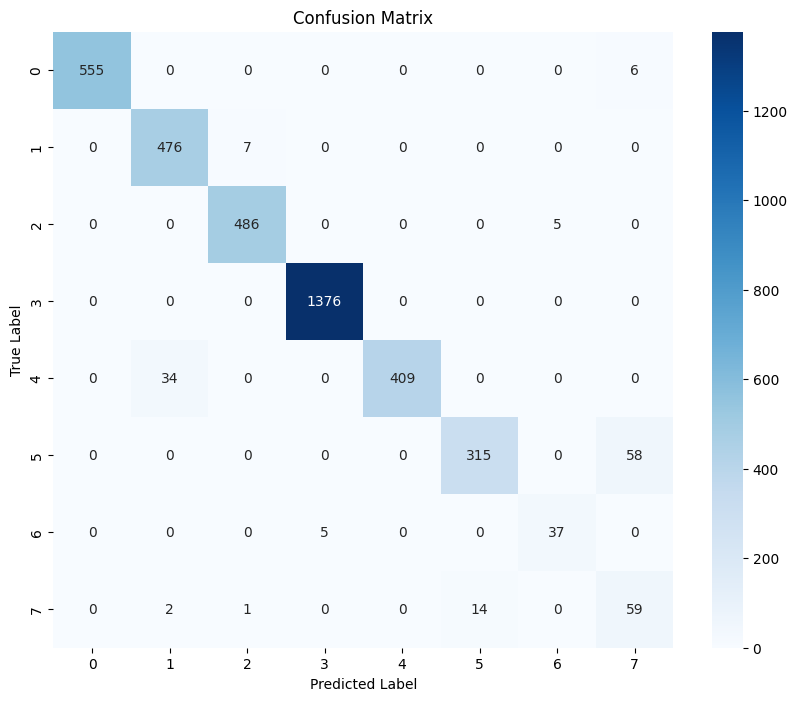

In [36]:
# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(visualization_dir, 'model_tuning_correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


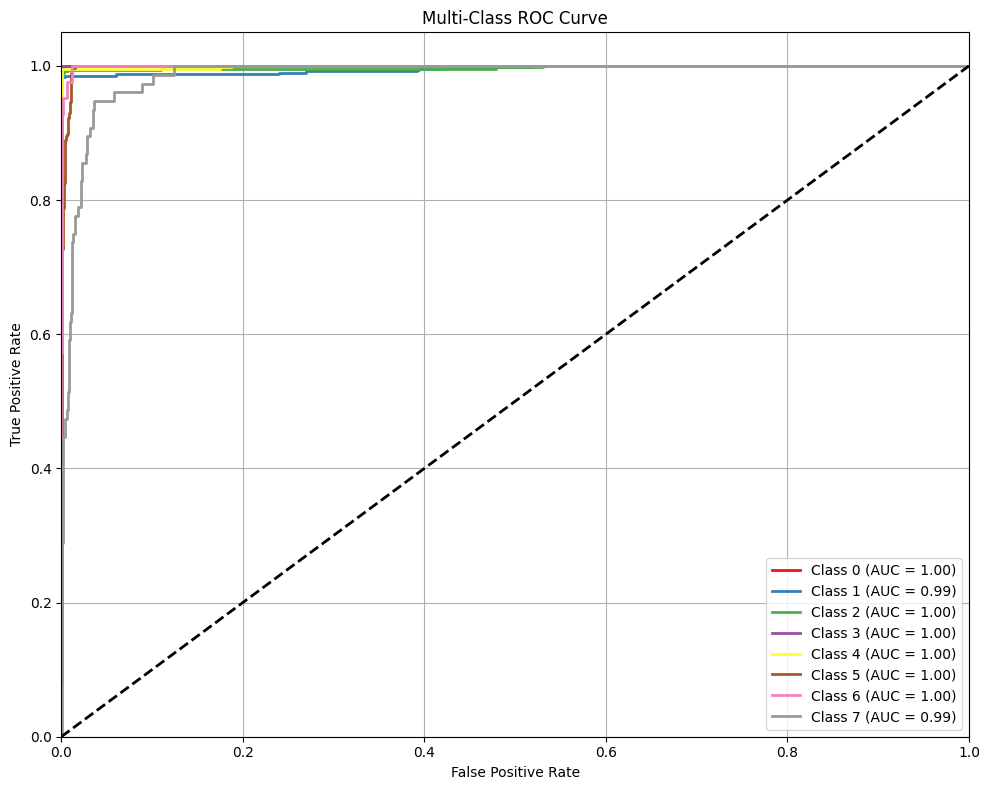

In [37]:
y_pred_proba = best_model_classifier.predict(X_test_seq)

# Binarisasi label (One-Hot Encoding untuk true labels)
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true_labels, classes=range(n_classes))

# ROC Curve per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve per kelas
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("Set1", n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})',
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'model_tuning_roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

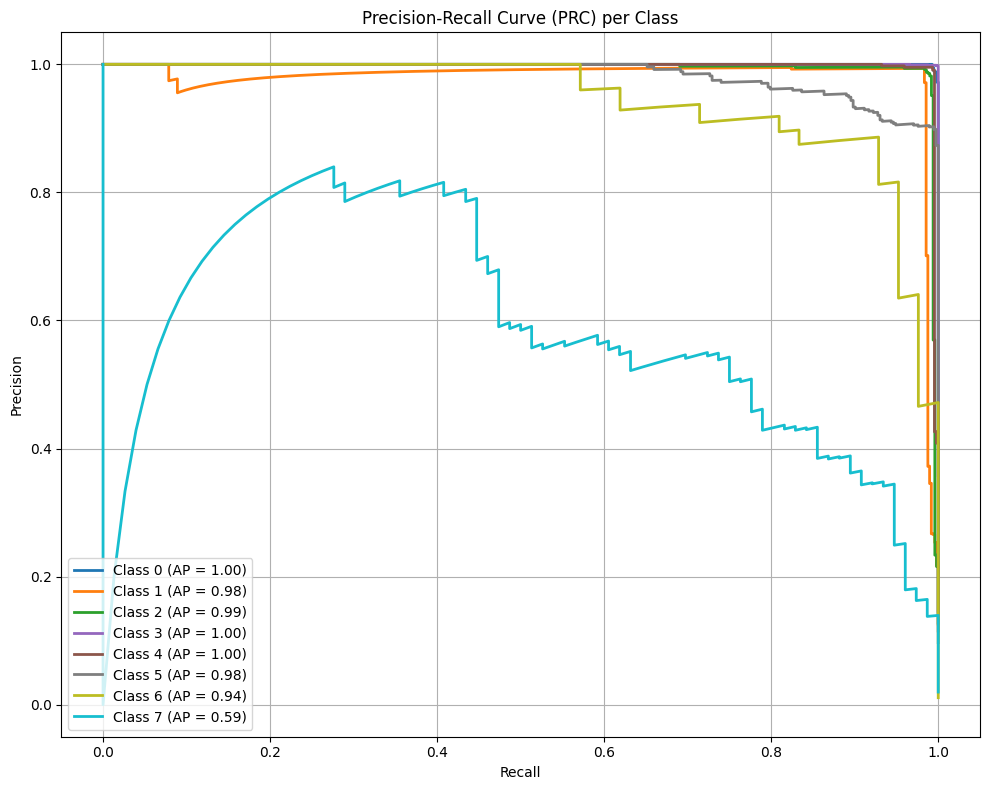

In [38]:
# Hitung Precision-Recall untuk setiap kelas
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])

# Plot Precision-Recall Curve per kelas
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", n_classes)

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f"Class {i} (AP = {average_precision[i]:.2f})",
             color=colors(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (PRC) per Class")
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'model_tuning_pr_curve.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [39]:
# Simpan model dalam format .keras
model_path = os.path.join(artifacts_dir, "Classifier_model_tuning.keras")
best_model_classifier.save(model_path)

In [37]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
# Bangun ulang model terbaik
best_model_test = build_model(best_hps)

# Train ulang model
history = best_model_test.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    class_weight=scaled_weight_dict,
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

Epoch 1/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.6165 - auc: 0.9165 - loss: 0.6681 - precision: 0.6818 - recall: 0.5479 - val_accuracy: 0.8921 - val_auc: 0.9919 - val_loss: 0.2844 - val_precision: 0.8937 - val_recall: 0.8912
Epoch 2/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9023 - auc: 0.9910 - loss: 0.2095 - precision: 0.9106 - recall: 0.8946 - val_accuracy: 0.9386 - val_auc: 0.9954 - val_loss: 0.1692 - val_precision: 0.9393 - val_recall: 0.9386
Epoch 3/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9476 - auc: 0.9954 - loss: 0.1140 - precision: 0.9515 - recall: 0.9432 - val_accuracy: 0.9875 - val_auc: 0.9966 - val_loss: 0.0751 - val_precision: 0.9877 - val_recall: 0.9873
Epoch 4/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9584 - auc: 0.9967 - loss: 0.0909 - precision: 0.9625 - recall: 0.9552 - val_accuracy: 0.9856 - val_auc: 0.9976 - val_loss: 0.0573 - val_precision: 0.9861 - val_recall: 0.9856
Epoch 5/20
949/949 ━━━━━

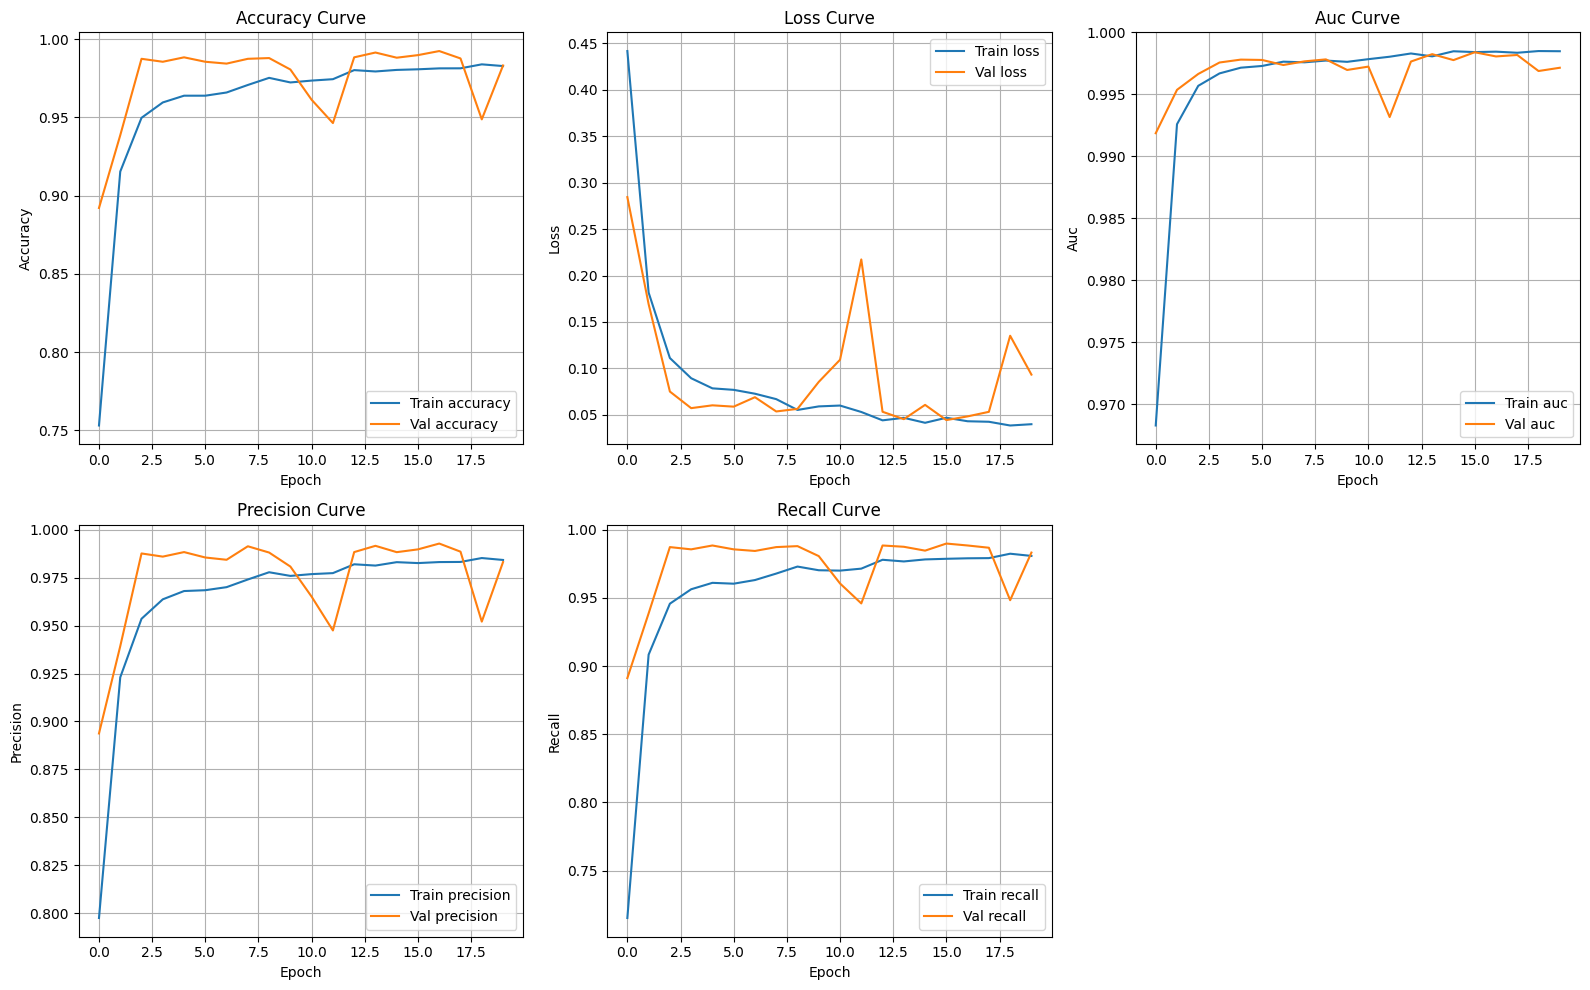

In [41]:
# Plot semua metrik dalam satu plot
metrics_to_plot = ['accuracy', 'loss', 'auc', 'precision', 'recall']
plt.figure(figsize=(16, 10))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric.capitalize()} Curve')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'model_tuning_curve_learning_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [42]:
y_pred = best_model_test.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       561
           1       0.98      1.00      0.99       476
           2       1.00      0.99      0.99       680
           3       1.00      0.98      0.99      2221
           4       1.00      0.99      0.99       496
           5       1.00      0.99      0.99       445
           6       0.51      1.00      0.67        45
           7       0.93      0.96      0.95        54

    accuracy                           0.99      4978
   macro avg       0.93      0.99      0.95      4978
weighted avg       0.99      0.99      0.99      4978



In [40]:
def build_lstm_autoencoder(hp):
    inputs = Input(shape=(sequence_length, n_features))

    # Encoder LSTM
    encoded = LSTM(
        units=hp.Int('encoder_units', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=False,
        dropout=hp.Float('encoder_dropout', 0.1, 0.5, step=0.1)
    )(inputs)

    # Latent Space (Dense layer)
    latent = Dense(
        units=hp.Int('latent_dim', min_value=8, max_value=64, step=8),
        activation='relu',
        name='latent_space'
    )(encoded)

    # Repeat for decoder
    repeated = RepeatVector(sequence_length)(latent)

    # Decoder LSTM
    decoded = LSTM(
        units=hp.Int('decoder_units', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=True,
        dropout=hp.Float('decoder_dropout', 0.1, 0.5, step=0.1)
    )(repeated)

    # Output layer
    outputs = TimeDistributed(Dense(n_features))(decoded)

    # Compile model
    model = Model(inputs, outputs, name='anomaly_detection_tuned')
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='mse',
        metrics=['mae','mse']
    )
    return model

In [41]:
class AutoencoderTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters

        # Ambil hyperparameter batch size dan callbacks
        batch_size = hp.Int("batch_size", 32, 128, step=32)
        
        # Buat callbacks dari hyperparameter
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=hp.Int('early_stop_patience', 3, 5, step=1),
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=hp.Choice('reduce_lr_factor', [0.2, 0.5]),
            patience=hp.Int('reduce_lr_patience', 1, 5),
            min_lr=1e-7,
            verbose=1
        )

        # Tambahkan callbacks ini ke argumen
        callbacks = [early_stop,reduce_lr]
        kwargs['callbacks'] = callbacks
        kwargs['batch_size'] = batch_size
        
        return super().run_trial(trial, *args, **kwargs)

    def score_trial(self, trial):
        val_loss = trial.metrics.get_last_value("val_loss")
        val_mae = trial.metrics.get_last_value("val_mae")
        val_mse = trial.metrics.get_last_value("val_mse")

        if None in [val_loss, val_mae, val_mse]:
            return float("-inf")

        # Konversi ke skor (semakin besar = semakin baik)
        loss_score = 1 / (1 + val_loss)
        mae_score = 1 / (1 + val_mae)
        mse_score = 1 / (1 + val_mse)

        score = 0.5 * loss_score + 0.3 * mae_score + 0.2 * mse_score
        return score

In [42]:
tuner_ae = AutoencoderTuner(
    hypermodel=build_lstm_autoencoder,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="model_tuning",
    project_name="combine_tuner_ae"
)

tuner_ae.search(
    X_train_ae_seq, X_train_ae_seq,
    validation_data=(X_val_ae_seq, X_val_ae_seq),
    epochs=20,
    verbose=1
)

Trial 2 Complete [00h 01m 11s]
val_loss: nan

Best val_loss So Far: nan
Total elapsed time: 00h 03m 29s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
224               |192               |encoder_units
0.5               |0.4               |encoder_dropout
16                |64                |latent_dim
224               |256               |decoder_units
0.1               |0.2               |decoder_dropout
0.00064614        |1.0623e-05        |learning_rate
64                |32                |batch_size
5                 |3                 |early_stop_patience
0.2               |0.2               |reduce_lr_factor
2                 |1                 |reduce_lr_patience

Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.0602 - mae: 0.1365 - mse: 0.0602 - val_loss: nan - val_mae: nan - val_mse: nan - learning_rate: 6.4614e-04
Epoch 2/20
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0242 - mae: 0.0778 - mse: 0.0242
Epoch 2: Reduce

RuntimeError: Number of consecutive failures exceeded the limit of 3.


In [90]:
best_model_autoencoder = tuner_ae.get_best_models(num_models=1)[0]
best_model_autoencoder.summary()

Model: "anomaly_detection_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 56)             │         3,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 56)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        30,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 9)          │           585 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,145 (211.50 KB)

 Trainable params: 54,145 (211.50 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Ambil trial terbaik
best_trial_ae = tuner_ae.oracle.get_best_trials(num_trials=1)[0]

# Ambil semua metrik dari trial tersebut
metrics = best_trial_ae.metrics

print("===== Hasil Trial Terbaik (Berdasarkan Gabungan Metrik) =====")
print(f"val_loss     : {metrics.get_last_value('val_loss')}")
print(f"val_mae      : {metrics.get_last_value('val_mae')}")
print(f"val_mse      : {metrics.get_last_value('val_mse')}")
print("\n===== Hyperparameter terbaik =====")
print(best_trial_ae.hyperparameters.values)

===== Hasil Trial Terbaik (Berdasarkan Gabungan Metrik) =====
val_loss     : 0.014909437857568264
val_mae      : 0.057631559669971466
val_mse      : 0.014909435994923115

===== Hyperparameter terbaik =====
{'encoder_units': 64, 'encoder_dropout': 0.1, 'latent_dim': 56, 'decoder_units': 64, 'decoder_dropout': 0.30000000000000004, 'learning_rate': 0.00044239207707403195, 'batch_size': 32, 'early_stop_patience': 4, 'reduce_lr_factor': 0.5, 'reduce_lr_patience': 3}


In [100]:
X_pred = best_model_autoencoder.predict(X_test_ae_seq)

# Hitung reconstruction error (bisa pakai MSE atau MAE)
reconstruction_error = np.mean(np.square(X_test_ae_seq - X_pred), axis=(1,2))

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [102]:
label_index = np.argmax(y_test_ae_seq, axis=1)
y_true = np.where(label_index == 3, 0, 1)

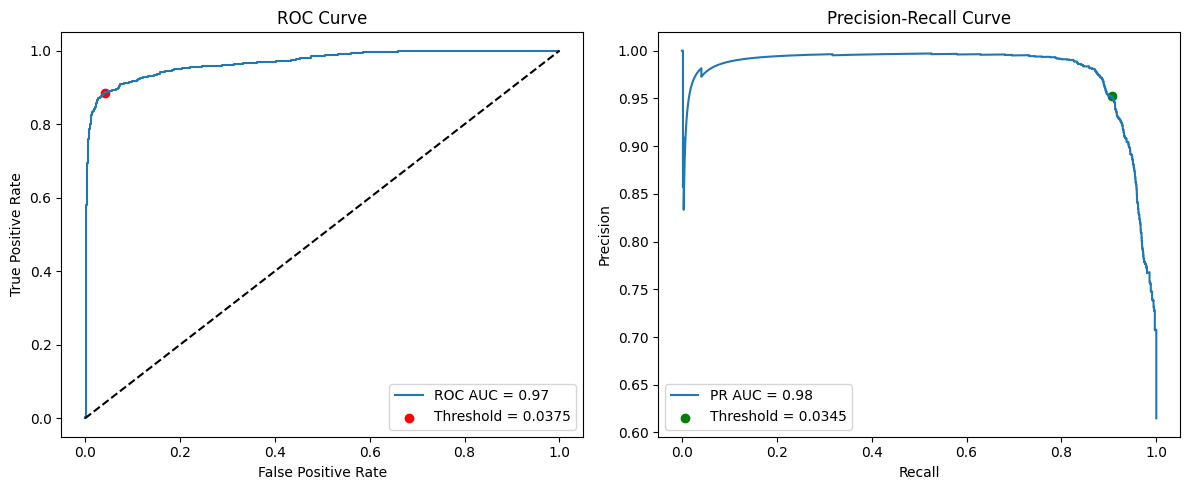

Optimal Threshold (ROC): 0.037464032408239735
Optimal Threshold (PR): 0.03454145463570569


In [118]:
# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, reconstruction_error)
roc_auc = auc(fpr, tpr)

# PR Curve
precision, recall, thresholds_pr = precision_recall_curve(y_true, reconstruction_error)
avg_prec = average_precision_score(y_true, reconstruction_error)

# Threshold ROC: Youden’s J statistic
j_scores = tpr - fpr
optimal_idx_roc = np.argmax(j_scores)
optimal_threshold_roc = thresholds_roc[optimal_idx_roc]

# Threshold PR: Best F1 Score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx_pr = np.argmax(f1_scores)
optimal_threshold_pr = thresholds_pr[optimal_idx_pr]

# Plot ROC and PR Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.scatter(fpr[optimal_idx_roc], tpr[optimal_idx_roc], c='red', label=f'Threshold = {optimal_threshold_roc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC = {avg_prec:.2f}')
plt.scatter(recall[optimal_idx_pr], precision[optimal_idx_pr], c='green', label=f'Threshold = {optimal_threshold_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()


plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'roc_pr_curve_ae.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Optimal Threshold (ROC):", optimal_threshold_roc)
print("Optimal Threshold (PR):", optimal_threshold_pr)

In [113]:
# Prediksi hasil anomaly (1=anomaly, 0=normal)
y_pred_binary = (reconstruction_error > optimal_threshold_roc).astype(int)

In [114]:
print("Classification Report:")
print(classification_report(y_true, y_pred_binary, target_names=["Normal", "Anomaly"]))

print("ROC AUC Score:", roc_auc_score(y_true, reconstruction_error))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.96      0.90      1632
     Anomaly       0.97      0.89      0.93      2605

    accuracy                           0.91      4237
   macro avg       0.91      0.92      0.91      4237
weighted avg       0.92      0.91      0.91      4237

ROC AUC Score: 0.9678667532272026
Confusion Matrix:
 [[1564   68]
 [ 298 2307]]


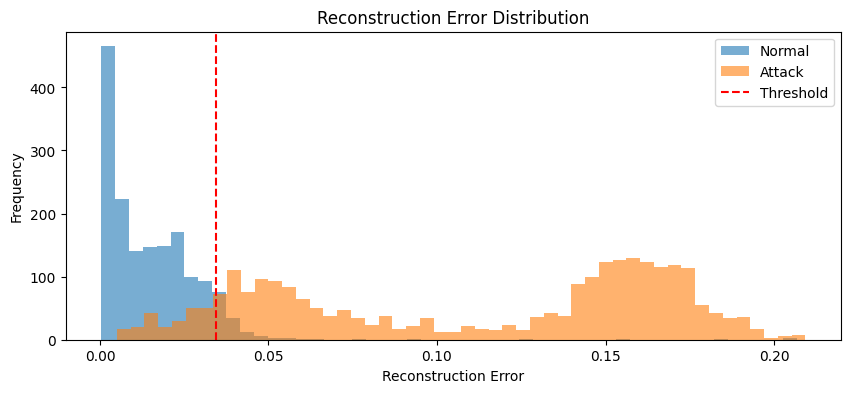

In [119]:
plt.figure(figsize=(10, 4))
plt.hist(reconstruction_error[y_true == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_error[y_true == 1], bins=50, alpha=0.6, label='Attack')
plt.axvline(optimal_threshold_pr, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.savefig(os.path.join(visualization_dir, 'recontruction_error.png'), dpi=300, bbox_inches='tight')
plt.show()

In [117]:
# Simpan model dalam format .keras
model_path_ae = os.path.join(artifacts_dir, "Anomaly_detection_tuning_model.keras")
best_model_autoencoder.save(model_path_ae)